In [1]:
import string
import sqlite3
import nltk
import pandas as pd
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
from nltk import FreqDist
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.sentiment import SentimentIntensityAnalyzer
from wordcloud import WordCloud
from textblob import TextBlob

## Read the data

In [2]:
conn = sqlite3.connect('data/database.db')
cursor = conn.cursor()

In [3]:
questions = pd.read_sql_query("SELECT * FROM question", conn)
questions

,id,title,body_with_tags,body_without_tags,votes,url,views,created_date,modified_date
0,1,Why is processing a sorted array faster than p...,"<div class=""s-prose js-post-body"" itemprop=""te...","\nIn this C++ code, sorting the data (before t...",27153,https://stackoverflow.com/q/11227809,1848348,2012-06-27 13:51:36,2023-09-19 09:35:58
1,2,How do I undo the most recent local commits in...,"<div class=""s-prose js-post-body"" itemprop=""te...",\nI accidentally committed the wrong files to ...,26030,https://stackoverflow.com/q/927358,13393115,2009-05-29 18:09:14,2023-11-16 03:37:28
2,3,How do I delete a Git branch locally and remot...,"<div class=""s-prose js-post-body"" itemprop=""te...",\nFailed Attempts to Delete a Remote Branch:\n...,20363,https://stackoverflow.com/q/2003505,11215663,2010-01-05 01:12:15,2023-11-07 21:50:24
3,4,What is the difference between 'git pull' and ...,"<div class=""s-prose js-post-body"" itemprop=""te...",\n\n\n\n\n\n\n\n\n\n\nWant to improve this pos...,13725,https://stackoverflow.com/q/292357,3428085,2008-11-15 09:51:09,2023-10-16 20:38:08
4,5,"What does the ""yield"" keyword do in Python?","<div class=""s-prose js-post-body"" itemprop=""te...",\n\n\n\n\n\n\n\n\n\n\nWant to improve this pos...,12790,https://stackoverflow.com/q/231767,3270534,2008-10-23 22:21:11,2023-08-10 04:37:11
...,...,...,...,...,...,...,...,...,...
2994,2995,How do I detect unsigned integer overflow?,"<div class=""s-prose js-post-body"" itemprop=""te...",\nI was writing a program in C++ to find all s...,733,https://stackoverflow.com/q/199333,442741,2008-10-13 22:53:21,2023-06-12 15:40:48
2995,2996,Difference between FetchType LAZY and EAGER in...,"<div class=""s-prose js-post-body"" itemprop=""te...",\nWhat is the difference between FetchType.LAZ...,732,https://stackoverflow.com/q/2990799,747181,2010-06-07 15:28:44,2023-03-25 13:04:12
2996,2997,Wildcards in jQuery selectors,"<div class=""s-prose js-post-body"" itemprop=""te...",\nI'm trying to use a wildcard to get the id o...,732,https://stackoverflow.com/q/5376431,544390,2011-03-21 10:34:08,2017-08-09 13:25:56
2997,2998,Proper way to initialize a C# dictionary with ...,"<div class=""s-prose js-post-body"" itemprop=""te...",\nI am creating a dictionary in a C# file with...,732,https://stackoverflow.com/q/17047602,728471,2013-06-11 15:11:50,2023-02-07 07:50:12


In [4]:
# Read answers that have been accepted limit to 3000
answers = pd.read_sql_query("SELECT * FROM answer WHERE accepted = 1", conn)
answers

,id,body_with_tags,body_without_tags,votes,url,accepted,created_date,question_id
0,1,"<div class=""s-prose js-post-body"" itemprop=""te...",\nYou are a victim of branch prediction fail.\...,34849,https://stackoverflow.com/a/11227902,1,2012-06-27 13:56:42,1
1,26,"<div class=""s-prose js-post-body"" itemprop=""te...","\nUndo a commit & redo\n$ git commit -m ""Somet...",28486,https://stackoverflow.com/a/927386,1,2009-05-29 18:13:42,2
2,56,"<div class=""s-prose js-post-body"" itemprop=""te...",\nExecutive Summary\ngit push -d <remote_name>...,25628,https://stackoverflow.com/a/2003515,1,2010-01-05 01:13:55,3
3,86,"<div class=""s-prose js-post-body"" itemprop=""te...","\nIn the simplest terms, git pull does a git f...",11450,https://stackoverflow.com/a/292359,1,2008-11-15 09:52:40,4
4,116,"<div class=""s-prose js-post-body"" itemprop=""te...","\nTo understand what yield does, you must unde...",17860,https://stackoverflow.com/a/231855,1,2008-10-23 22:48:44,5
...,...,...,...,...,...,...,...,...
2712,60227,"<div class=""s-prose js-post-body"" itemprop=""te...",\nTo expand on the answers others have given:\...,638,https://stackoverflow.com/a/643810,1,2009-03-13 17:37:20,2993
2713,60245,"<div class=""s-prose js-post-body"" itemprop=""te...",\nString literals\nEscaping single quotes ' by...,1245,https://stackoverflow.com/a/12320729,1,2012-09-07 15:06:16,2994
2714,60283,"<div class=""s-prose js-post-body"" itemprop=""te...",\nSometimes you have two entities and there's ...,1407,https://stackoverflow.com/a/2991015,1,2010-06-07 15:53:56,2996
2715,60301,"<div class=""s-prose js-post-body"" itemprop=""te...","\nTo get all the elements starting with ""jande...",1388,https://stackoverflow.com/a/5376445,1,2011-03-21 10:35:16,2997


## Preprocess the text

We tokenize and Lemmatize the text.

In [5]:
def preprocess_text(text):
    # Parse the HTML code
    soup = BeautifulSoup(text, 'html.parser')

    # Remove all pre tags and their contents
    for pre_tag in soup.find_all('pre'):
        pre_tag.decompose()

    # Get the modified HTML code
    code_removed_text = soup.get_text()

    lowered_text = code_removed_text.lower()

    tokens = word_tokenize(lowered_text)
    filtered_tokens = [token for token in tokens if token not in (stopwords.words('english') + list(string.punctuation)) + ["''", "``", "'s", "n't"]]
    
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in filtered_tokens]
    
    processed_text = ' '.join(lemmatized_tokens)
    return processed_text

In [6]:
questions['processed_body'] = questions['body_with_tags'].apply(preprocess_text)
print('Questions processed')
answers['processed_body'] = answers['body_with_tags'].apply(preprocess_text)
print('Answers processed')

Questions processed
Answers processed


In [7]:
questions['processed_body'].head()
answers['processed_body'].head()

0    victim branch prediction fail branch predictio...
1    undo commit redo git reset command responsible...
2    executive summary note case remote_name origin...
3    simplest term git pull git fetch followed git ...
4    understand yield must understand generator und...
Name: processed_body, dtype: object

## Find out the most common words in questions and answers

In [8]:
# a function that returns frequency distribution of all words in all text in a column
def get_all_words_freq_dist(df):
    all_words = ' '.join(df).split()
    fdist = FreqDist(all_words)
    return fdist

In [9]:
questions_fdist = get_all_words_freq_dist(questions['processed_body'])
answers_fdist = get_all_words_freq_dist(answers['processed_body'])

# Print the 10 most common words
print(questions_fdist.most_common(20))
print(answers_fdist.most_common(20))


[('question', 1020), ('file', 928), ('like', 892), ('answer', 873), ('want', 855), ('using', 812), ('way', 782), ('use', 738), ("'m", 675), ('would', 662), ('code', 651), ('get', 626), ('one', 614), ('git', 605), ('string', 515), ('work', 468), ('example', 439), ('need', 437), ('branch', 436), ('value', 414)]
[('use', 3231), ('file', 1585), ('using', 1526), ('function', 1505), ('one', 1369), ('also', 1333), ('object', 1330), ('example', 1325), ('value', 1317), ('like', 1300), ('code', 1270), ('git', 1229), ('need', 1210), ('want', 1189), ('method', 1150), ('see', 1032), ('type', 981), ('work', 971), ('class', 942), ('get', 880)]


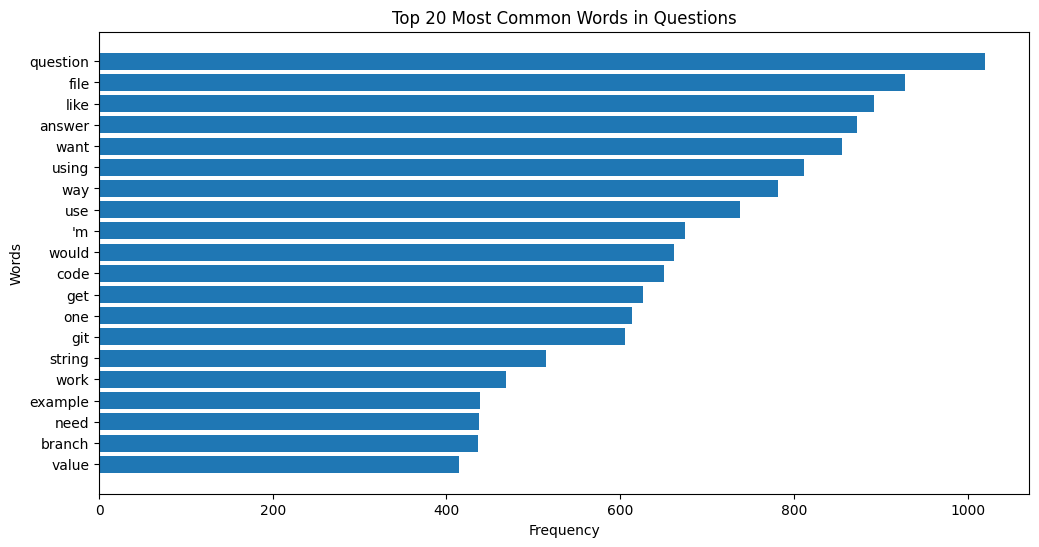

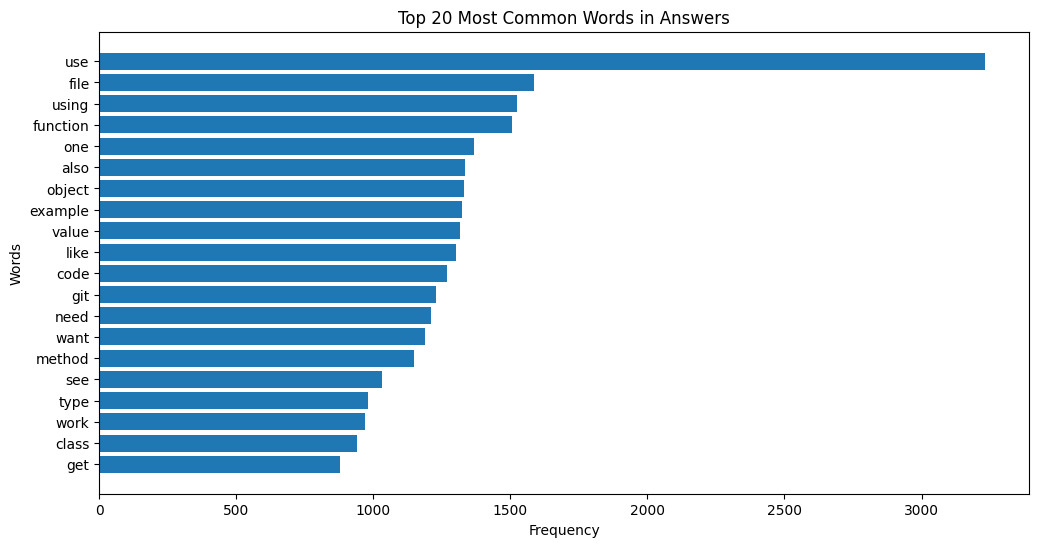

In [10]:
# Get the most common 20 words for questions
top_questions_words = questions_fdist.most_common(20)
questions_words, questions_counts = zip(*top_questions_words)
questions_words = list(reversed(questions_words))
questions_counts = list(reversed(questions_counts))

# Get the most common 20 words for answers
top_answers_words = answers_fdist.most_common(20)
answers_words, answers_counts = zip(*top_answers_words)
answers_words = list(reversed(answers_words))
answers_counts = list(reversed(answers_counts))

# Plot for questions
plt.figure(figsize=(12, 6))
plt.barh(range(len(questions_words)), questions_counts, align='center')
plt.yticks(range(len(questions_words)), questions_words)
plt.title('Top 20 Most Common Words in Questions')
plt.xlabel('Frequency')
plt.ylabel('Words')
plt.show()

# Plot for answers
plt.figure(figsize=(12, 6))
plt.barh(range(len(answers_words)), answers_counts, align='center')
plt.yticks(range(len(answers_words)), answers_words)
plt.title('Top 20 Most Common Words in Answers')
plt.xlabel('Frequency')
plt.ylabel('Words')
plt.show()

## Sentiment Analysis

In [11]:
analyzer = SentimentIntensityAnalyzer()

def get_sentiment(text):
    scores = analyzer.polarity_scores(text)
    return scores

In [12]:
sent = questions['processed_body'].apply(get_sentiment)
questions['sentiment_neg'] = sent.apply(lambda x: x['neg'])
questions['sentiment_neu'] = sent.apply(lambda x: x['neu'])
questions['sentiment_pos'] = sent.apply(lambda x: x['pos'])

sent = answers['processed_body'].apply(get_sentiment)
answers['sentiment_neg'] = sent.apply(lambda x: x['neg'])
answers['sentiment_neu'] = sent.apply(lambda x: x['neu'])
answers['sentiment_pos'] = sent.apply(lambda x: x['pos'])

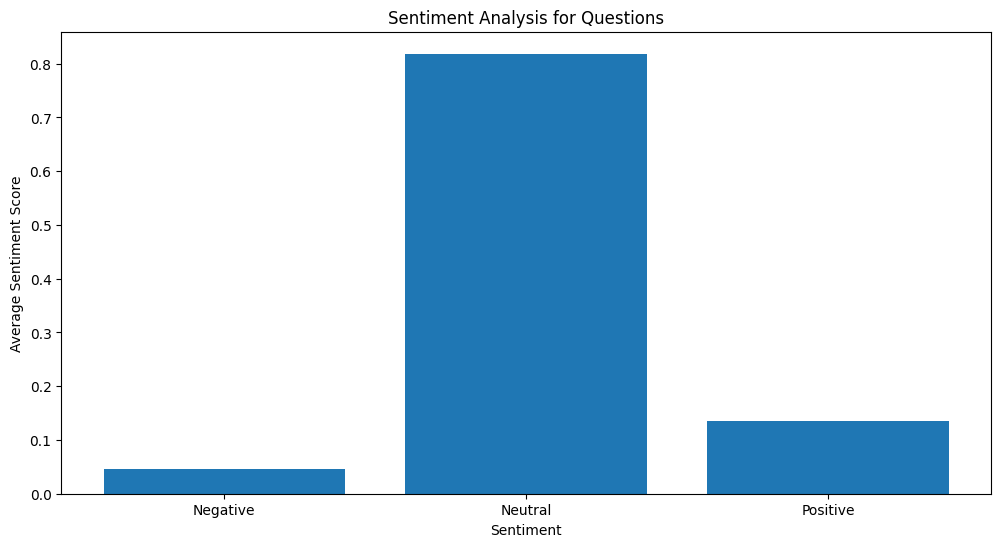

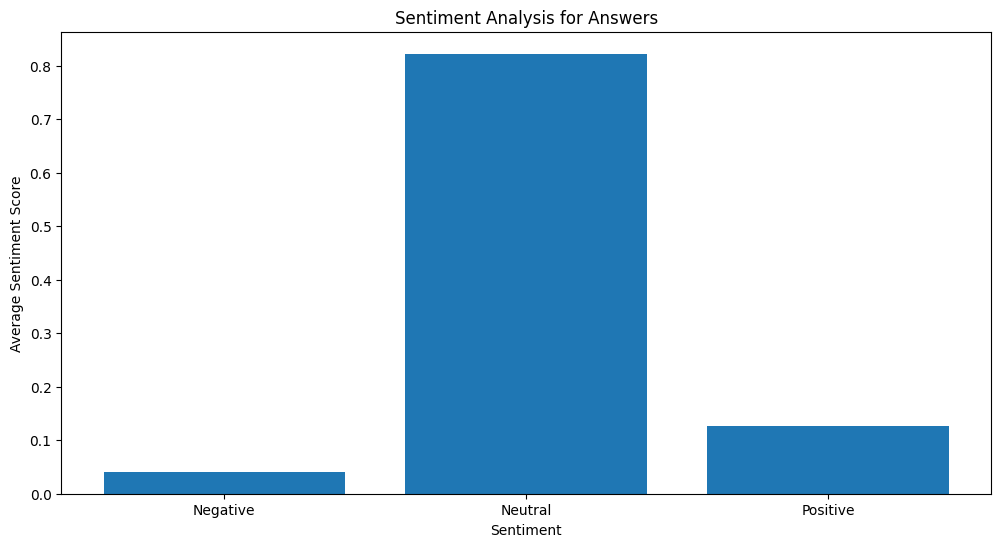

In [13]:
# Plotting for questions
plt.figure(figsize=(12, 6))
plt.bar(['Negative', 'Neutral', 'Positive'], questions[['sentiment_neg', 'sentiment_neu', 'sentiment_pos']].mean())
plt.title('Sentiment Analysis for Questions')
plt.xlabel('Sentiment')
plt.ylabel('Average Sentiment Score')
plt.show()

# Plotting for answers
plt.figure(figsize=(12, 6))
plt.bar(['Negative', 'Neutral', 'Positive'], answers[['sentiment_neg', 'sentiment_neu', 'sentiment_pos']].mean())
plt.title('Sentiment Analysis for Answers')
plt.xlabel('Sentiment')
plt.ylabel('Average Sentiment Score')
plt.show()

In [14]:
def get_subjectivity(text):
    analysis = TextBlob(str(text))
    return analysis.sentiment.subjectivity

In [15]:
questions['subjectivity'] = questions['processed_body'].apply(get_subjectivity)
answers['subjectivity'] = answers['processed_body'].apply(get_subjectivity)

# Print average subjectivity for questions and answers
print("Average Subjectivity for Questions:", questions['subjectivity'].mean())
print("Average Subjectivity for Answers:", answers['subjectivity'].mean())

Average Subjectivity for Questions: 0.3329398387679219
Average Subjectivity for Answers: 0.3678047133835599


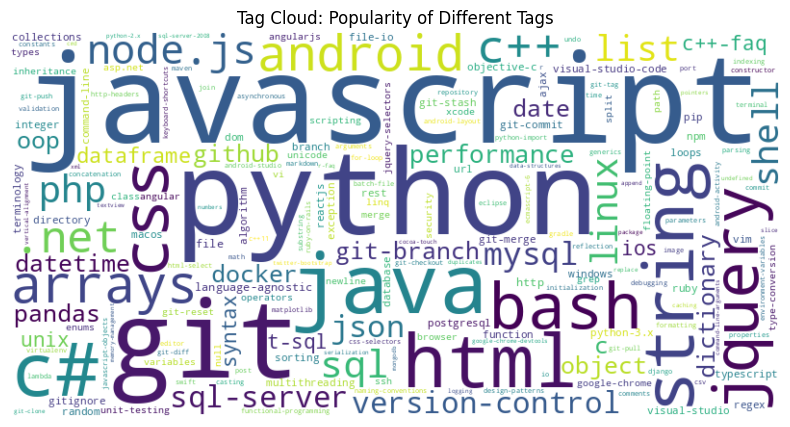

In [16]:
top_tags = pd.read_sql_query("""
    SELECT Tag.name, COUNT(*) AS count
    FROM Question
    JOIN Question_Tag ON Question.id = Question_Tag.question_id
    JOIN Tag ON Question_Tag.tag_id = Tag.id
    GROUP BY Tag.name
    ORDER BY count DESC
""",
conn)
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(dict(zip(top_tags['name'], top_tags['count'])))
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Tag Cloud: Popularity of Different Tags')
plt.show()

Text(0.5, 1.0, 'Question Body Word Cloud')

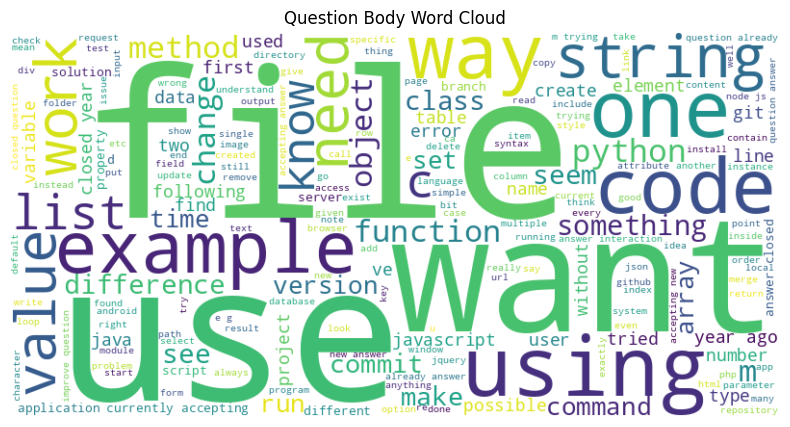

In [17]:
all_question_bodies = ' '.join(questions['processed_body'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_question_bodies)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Question Body Word Cloud')

Text(0.5, 1.0, 'Answer Body Word Cloud')

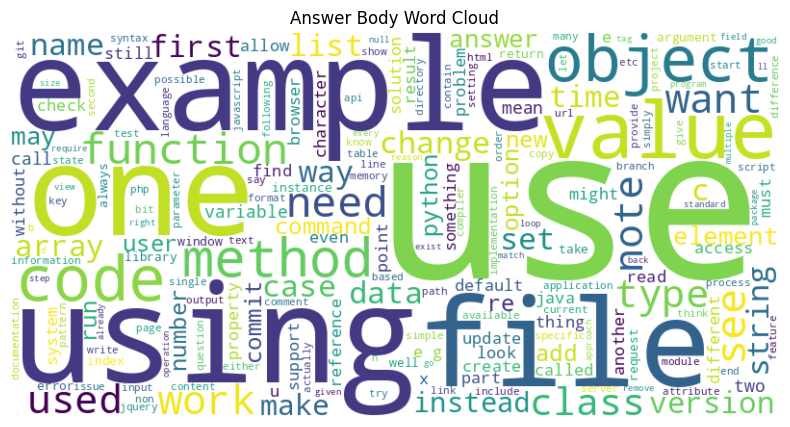

In [18]:
all_answer_bodies = ' '.join(answers['processed_body'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_answer_bodies)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Answer Body Word Cloud')